# Imports

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import signal
import matplotlib.pyplot as plt
from pyampd.ampd import find_peaks, find_peaks_original, find_peaks_adaptive
import mrmr

import mat73

# Loading Data

In [2]:
data = mat73.loadmat("dataset/VitalDB_AAMI_Test_Subset.mat")
data["Subset"]["Signals"] = [np.array(array) for array in data["Subset"]["Signals"]]
data_df = pd.DataFrame(data["Subset"])

In [3]:
data_df["Gender"] = data_df["Gender"].astype("str").replace(["['M']", "['F']"], [1, 0]).astype("category")

In [4]:
data_df.loc[:, "Signals"] = data_df.loc[:, "Signals"].apply(lambda x: x[1])
data_df = data_df.rename(
    columns = {
        "Age": "age",
        "BMI": "bmi",
        "DBP": "dbp",
        "SBP": "sbp",
        "Gender": "gender",
        "Height": "height",
        "Signals": "signal",
        "Subject": "subject",
        "Weight": "weight"
    }
)
data_df = data_df[["gender", "age", "weight", "height", "bmi", "signal", "dbp", "sbp"]]

In [5]:
udf = pd.read_json("dataset/unified.json")
udf.index.name = "number"

In [6]:
data_df

,gender,age,weight,height,bmi,signal,dbp,sbp
0,1,26.0,89.05,183.9,26.3,"[0.09558564133507576, 0.08034762507124568, 0.0...",57.966649,99.987120
1,1,26.0,89.05,183.9,26.3,"[0.9297905141750652, 0.9399888619322257, 0.939...",58.320482,100.759058
2,1,26.0,89.05,183.9,26.3,"[0.12351961433660608, 0.12247612139897121, 0.1...",59.022303,102.019124
3,1,26.0,89.05,183.9,26.3,"[0.06187197844682026, 0.04972063498197406, 0.0...",59.802165,102.834648
4,1,26.0,89.05,183.9,26.3,"[0.17820817689407467, 0.17872682753601465, 0.1...",58.068798,100.265742
...,...,...,...,...,...,...,...,...
661,1,51.0,81.60,186.0,23.6,"[0.2612889579209523, 0.24247805817040835, 0.22...",67.354875,158.041383
662,1,51.0,81.60,186.0,23.6,"[0.6524835843199924, 0.6342669050545015, 0.618...",66.764646,154.649431
663,1,51.0,81.60,186.0,23.6,"[0.203036472140417, 0.18776552828829857, 0.172...",67.429088,160.446045
664,1,51.0,81.60,186.0,23.6,"[1.0, 0.99346053784738, 0.982223957031127, 0.9...",69.336335,165.430557


In [7]:
udf = data_df

In [8]:
udf.head(n = 10)

,gender,age,weight,height,bmi,signal,dbp,sbp
0,1,26.0,89.05,183.9,26.3,"[0.09558564133507576, 0.08034762507124568, 0.0...",57.966649,99.987120
1,1,26.0,89.05,183.9,26.3,"[0.9297905141750652, 0.9399888619322257, 0.939...",58.320482,100.759058
2,1,26.0,89.05,183.9,26.3,"[0.12351961433660608, 0.12247612139897121, 0.1...",59.022303,102.019124
3,1,26.0,89.05,183.9,26.3,"[0.06187197844682026, 0.04972063498197406, 0.0...",59.802165,102.834648
4,1,26.0,89.05,183.9,26.3,"[0.17820817689407467, 0.17872682753601465, 0.1...",58.068798,100.265742
5,1,26.0,89.05,183.9,26.3,"[0.13230081516686862, 0.14727902369284, 0.1684...",58.066471,100.090907
6,1,26.0,89.05,183.9,26.3,"[0.6627800793261099, 0.6069374826477312, 0.552...",56.624072,97.468498
7,1,26.0,89.05,183.9,26.3,"[0.1586539613699744, 0.16687436293732044, 0.17...",67.673304,124.709176
8,1,26.0,89.05,183.9,26.3,"[0.17500208431085593, 0.17200604477920908, 0.1...",66.456139,120.549328
9,1,26.0,89.05,183.9,26.3,"[0.1390803655136121, 0.1436689542195931, 0.146...",67.183064,122.249314


# Constructing Features Data Frame

In [9]:
fdf = udf[["gender", "age", "height", "weight", "bmi", "signal", "sbp", "dbp"]]

In [10]:
fdf.head(n = 10)

,gender,age,height,weight,bmi,signal,sbp,dbp
0,1,26.0,183.9,89.05,26.3,"[0.09558564133507576, 0.08034762507124568, 0.0...",99.987120,57.966649
1,1,26.0,183.9,89.05,26.3,"[0.9297905141750652, 0.9399888619322257, 0.939...",100.759058,58.320482
2,1,26.0,183.9,89.05,26.3,"[0.12351961433660608, 0.12247612139897121, 0.1...",102.019124,59.022303
3,1,26.0,183.9,89.05,26.3,"[0.06187197844682026, 0.04972063498197406, 0.0...",102.834648,59.802165
4,1,26.0,183.9,89.05,26.3,"[0.17820817689407467, 0.17872682753601465, 0.1...",100.265742,58.068798
5,1,26.0,183.9,89.05,26.3,"[0.13230081516686862, 0.14727902369284, 0.1684...",100.090907,58.066471
6,1,26.0,183.9,89.05,26.3,"[0.6627800793261099, 0.6069374826477312, 0.552...",97.468498,56.624072
7,1,26.0,183.9,89.05,26.3,"[0.1586539613699744, 0.16687436293732044, 0.17...",124.709176,67.673304
8,1,26.0,183.9,89.05,26.3,"[0.17500208431085593, 0.17200604477920908, 0.1...",120.549328,66.456139
9,1,26.0,183.9,89.05,26.3,"[0.1390803655136121, 0.1436689542195931, 0.146...",122.249314,67.183064


# Preprocessing and Feature Extraction

In [17]:
def extract_features (information):
    sig = information["signal"]
    
    # Z-score Normalized Signal

    sig = (np.array(sig) - np.mean(sig)) / np.std(sig)
    
    # Signal Filteration
    
    b, a = signal.butter(6, 0.02)
    sig = signal.filtfilt(b, a, sig, padlen = 150)
    
    # Baseline Correction
    
    def correct_baseline (signal):
        x = np.arange(signal.shape[0])
        model = np.poly1d(np.polyfit(x, signal, 4))
        curve = model(x)
        return signal - curve
    
    sig = correct_baseline(sig)
    
    # Derivatives
    
    def gradient (x):
        grad = np.gradient(x)
        grad = (np.array(grad) - np.mean(grad)) / np.std(grad)
        return grad
    
    grad = gradient(sig)
    gradgrad = gradient(grad)
    g2 = gradgrad
    
    # Detection of Maximum and Minimum Points using AMPD Algorithm
    
    peaks = find_peaks(sig)
    throughs = find_peaks(np.negative(sig))
    
    # Ascending and Descending Sections and Detection of Foots and Systolic Peaks
    
    ascending_sections = []
    descending_sections = []
    
    systolic_peaks = [x for x in peaks if x != 0 and x != len(sig) - 1]
    
    foots = set()
    
    for i in range(1, len(throughs)):
        ta, tb = throughs[i - 1], throughs[i]
            
        if ta == 0 or tb == 0 or ta == len(sig) - 1 or tb == len(sig) - 1:
            continue
        
        peak = 0
        for y in peaks:
            if ta < y < tb:
                peak = y
                break
    
        if not peak:
            continue
        
        ascending_section = throughs[i - 1], peak
        descending_section = peak, throughs[i]
    
        ascending_sections.append(ascending_section)
        descending_sections.append(descending_section)
    
        foots.add(throughs[i - 1])
        foots.add(throughs[i])
    
    foots = sorted(list(foots))
    
    # Detection of Maximum Slope Points
    
    max_slope_points = [
        np.argmax(grad[a:b]) + a
        for a, b in ascending_sections
    ]
    
    # Detection of Diastolic Peaks
    
    diastolic_peaks = []
    
    for a, b in descending_sections:
        diastolic_peak = -1
    
        candidates, _ = signal.find_peaks(sig[a:b])
        candidates = np.array(candidates) + a
    
        for candidate in candidates.tolist():
            if candidate > a + 25 and candidate < b - 25 and g2[candidate] < 0:
                diastolic_peak = candidate
                break
    
        if diastolic_peak == -1:
            g2_mins = find_peaks(np.negative(g2[a:b])) + a
            g2_mins = [peak for peak in g2_mins if a + 25 < peak < b - 25]
            if g2_mins:
                diastolic_peak = g2_mins[int((len(g2_mins) - 1) / 2)]
            else:
                diastolic_peak = int(a + (b - a) * 0.75)

        diastolic_peaks.append(diastolic_peak)
    
    # Detection of Dicrotic Notchs
    
    notchs = []
    
    for i, (a, b) in enumerate(descending_sections):
        s, e = a, diastolic_peaks[i]
    
        slope = (sig[e] - sig[s]) / (e - s)
        h = sig[s] - slope * s
        xs = np.arange(s, e)
        line = slope * xs + h
    
        notch = np.argmin(sig[s:e] - line) + s
    
        WINDOW = 25
    
        candidates, _ = signal.find_peaks(np.negative(sig[a:b]))
        candidates = np.array(candidates) + a
    
        for candidate in candidates:
            if notch - WINDOW <= candidate <= notch + WINDOW:
                notch = candidate
                break
        
        notchs.append(notch)
    
    # Detection of Inflection Point
    
    inflections = []
    
    for i, v in enumerate(notchs):
        a, b = v, diastolic_peaks[i]
        candidates = find_peaks_original(grad)
        candidates = [candidate for candidate in candidates if a < candidate < b]
        if candidates:
            inflections.append(candidates[int(len(candidates) / 2)])
        else:
            inflections.append(int((a + b) / 2))
    
    # Feature Extraction
    
    def crossing_value (array, value):
            indices = set()
            for i in range(len(array) - 1):
                if array[i] == value:
                    indices.add(i)
                elif (array[i] - value) * (array[i + 1] - value) < 0:
                    indices.add(i + 0.5)
            return np.array(sorted(list(indices)))
    
    features = {}
    
    features["x"] = sig[systolic_peaks[0]] - sig[foots[0]]
    
    e, s = foots[1], foots[0]
    slope = (sig[e] - sig[s]) / (e - s)
    h = sig[s] - slope * s
    xs = np.arange(s, e)
    line = slope * xs + h
    features["y"] = sig[diastolic_peaks[0]] - line[diastolic_peaks[0] - s]
    
    features["z"] = sig[notchs[0]] - line[notchs[0] - s]
    features["t1"] =  systolic_peaks[0] - foots[0]
    features["t2"] =  diastolic_peaks[0] - foots[0]
    features["t3"] =  notchs[0] - foots[0]
    features["delta_t"] =  features["t2"] - features["t1"]
    features["tpi"] =  foots[1] - foots[0]
    features["tpp"] =  systolic_peaks[1] - systolic_peaks[0]
    
    half_height = features["x"] / 2 + sig[foots[0]]
    indices = crossing_value(sig, half_height)
    features["pulse_width"] = int(indices[1] - indices[0])
    
    features["y/x"] = features["y"] / features["x"]
    features["(x-y)/x"] = (features["x"] - features["y"]) / features["x"]
    features["t1/x"] = features["t1"] / features["x"]
    features["y/(tpi-t3)"] = features["x"] / (features["tpi"] - features["t2"])
    features["t1/tpp"] = features["t1"] / features["tpp"]
    features["t2/tpp"] = features["t2"] / features["tpp"]
    features["t3/tpp"] = features["t3"] / features["tpp"]
    features["delta_t/tpp"] = features["delta_t"] / features["tpp"]
    features["z/x"] = features["z"] / features["x"]
    features["t2/z"] = features["t2"] / features["z"]
    features["t3/y"] = features["t3"] / features["y"]
    features["x/(tpi-t1)"] = features["x"] / (features["tpi"] - features["t1"])
    features["z/(tpi-t2)"] = features["z"] / (features["tpi"] - features["t2"])

    for w in [10, 25, 33, 50, 66, 75]:
        candidates = crossing_value(sig, sig[foots[0]] + (w / 100) * features["x"])
        candidates = [candidate for candidate in candidates if foots[0] < candidate < foots[1]]
        if not candidates:
            candidates = [foots[0], foots[1]]
        features[f"width{w}"] = candidates[-1] - candidates[0]
        features[f"width{w}/t1"] = features[f"width{w}"] / features["t1"]
        features[f"width{w}/t2"] = features[f"width{w}"] / features["t2"]
        features[f"width{w}/t3"] = features[f"width{w}"] / features["t3"]
        features[f"width{w}/delta_t"] = features[f"width{w}"] / features["delta_t"]
        features[f"width{w}/tpi"] = features[f"width{w}"] / features["tpi"]

    grad_peaks = find_peaks(grad)
    a1 = 0.5 * (foots[0] + foots[1])
    for peak in grad_peaks:
        if foots[0] < peak < foots[1]:
            a1 = peak
            break

    gradgrad_peaks = find_peaks(gradgrad)
    a2 = 0
    for peak in gradgrad_peaks:
        if peak > a1:
            a2 = peak
            break

    grad_throughs = find_peaks(np.negative(grad))
    b1 = 0
    for through in grad_throughs:
        if through > a1:
            b1 = through
            break

    gradgrad_throughs = find_peaks(np.negative(gradgrad))
    b2 = 0
    for through in gradgrad_throughs:
        if through > a2:
            b2 = through
            break

    features["a1"] = a1
    features["ta1"] = a1 - foots[0]
    features["a2"] = a2
    features["ta2"] = a2 - foots[0]
    features["b1"] = b1
    features["tb1"] = b1 - foots[0]
    features["b2"] = b2
    features["tb2"] = b2 - foots[0]
    
    features["b2/a2"] = features["b2"] / features["a2"]
    features["b1/a1"] = features["b1"] / features["a1"]
    features["ta1/tpp"] = features["ta1"] / features["tpp"]
    features["tb1/tpp"] = features["tb1"] / features["tpp"]
    features["tb2/tpp"] = features["tb2"] / features["tpp"]
    features["ta2/tpp"] = features["ta2"] / features["tpp"]
    features["(ta1-ta2)/tpp"] = (features["ta1"] - features["ta2"]) / features["tpp"]
    features["(tb1-tb2)/tpp"] = (features["tb1"] - features["tb2"]) / features["tpp"]

    for feature in ["delta_t", "t1", "t2", "t3", "tpi", "tpp"]:
        features[f"height/{feature}"] = information["height"] / features[feature]
        features[f"weight/{feature}"] = information["weight"] / features[feature]
        features[f"bmi/{feature}"] = information["bmi"] / features[feature]
    
    return features

In [18]:
for i in tqdm(range(fdf.shape[0])):
    features = extract_features(fdf.loc[i])
    for key, value in features.items():
        fdf.loc[i, key] = value

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 666/666 [00:51<00:00, 12.97it/s]


In [19]:
fdf.drop(columns = ["signal"], inplace = True)

In [20]:
fdf.describe()

,age,height,weight,bmi,sbp,dbp,x,y,z,t1,...,bmi/t2,height/t3,weight/t3,bmi/t3,height/tpi,weight/tpi,bmi/tpi,height/tpp,weight/tpp,bmi/tpp
count,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,...,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000
mean,57.258258,164.327477,63.248498,23.308859,134.672982,75.394584,1.332233,0.208092,0.939455,3.506006,...,0.242423,2.491710,0.958340,0.353034,1.487094,0.571361,0.210469,1.510894,0.580726,0.214259
std,13.510874,8.979325,11.895374,3.297923,30.896424,18.222632,0.674988,0.118192,0.795136,63.040534,...,0.057878,0.757379,0.347156,0.118820,0.308847,0.159783,0.051516,0.300794,0.158755,0.052850
min,16.000000,143.200000,36.200000,15.600000,72.819147,37.720506,0.059455,0.012259,0.011354,-198.000000,...,0.070288,0.475676,0.206445,0.084384,0.446686,0.152305,0.063401,0.631225,0.260656,0.081148
25%,51.000000,158.000000,54.400000,20.900000,106.873321,60.249409,0.753356,0.107573,0.222453,-52.750000,...,0.200255,1.906120,0.681348,0.261128,1.277899,0.460730,0.172789,1.299286,0.464612,0.175735
50%,57.000000,164.400000,62.500000,23.500000,135.111206,73.566055,1.322955,0.213582,0.662243,44.500000,...,0.236572,2.544364,0.931911,0.344018,1.466092,0.539786,0.205907,1.495535,0.550679,0.207256
75%,67.000000,170.225000,71.950000,25.700000,155.387913,90.023394,1.898177,0.297730,1.668091,58.000000,...,0.274304,3.044787,1.160871,0.433929,1.674872,0.656217,0.239815,1.709904,0.677358,0.244418
max,89.000000,186.000000,97.900000,31.700000,214.231187,131.789636,3.190914,1.082017,2.702756,293.000000,...,0.483871,5.206667,2.436667,1.000000,2.487324,1.205634,0.410959,2.950000,1.378333,0.468852


# Correlation Matrix of Features

In [21]:
corr = fdf.corr(method = "spearman")

In [22]:
corr

,gender,age,height,weight,bmi,sbp,dbp,x,y,z,...,bmi/t2,height/t3,weight/t3,bmi/t3,height/tpi,weight/tpi,bmi/tpi,height/tpp,weight/tpp,bmi/tpp
gender,1.000000,-0.009467,0.698464,0.451274,0.075216,-0.139057,-0.074088,0.063221,0.057946,0.021195,...,0.009716,0.060067,0.185126,-0.011948,0.118584,0.273895,0.008802,0.079443,0.246773,-0.021450
age,-0.009467,1.000000,-0.318384,-0.157597,0.044978,0.100730,-0.011714,0.109445,0.099139,0.075049,...,-0.012226,-0.095736,-0.106018,-0.006608,-0.140805,-0.121817,-0.005107,-0.088583,-0.093499,0.039079
height,0.698464,-0.318384,1.000000,0.646215,0.102364,-0.122832,-0.053360,-0.002121,-0.004971,0.006941,...,0.069738,0.176415,0.336470,0.052716,0.262686,0.452301,0.068917,0.224718,0.426271,0.032587
weight,0.451274,-0.157597,0.646215,1.000000,0.804848,-0.078087,-0.001080,-0.004882,0.040658,0.013737,...,0.436189,0.086538,0.478764,0.311399,0.095254,0.620309,0.409449,0.102057,0.637169,0.415147
bmi,0.075216,0.044978,0.102364,0.804848,1.000000,-0.024649,0.033340,-0.035660,0.027379,-0.013865,...,0.540958,-0.013667,0.380207,0.381253,-0.060014,0.479415,0.504363,-0.023697,0.522161,0.543151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
weight/tpi,0.273895,-0.121817,0.452301,0.620309,0.479415,0.024456,0.100606,-0.315932,-0.425092,-0.218322,...,0.890540,0.483543,0.699076,0.601247,0.790573,1.000000,0.905646,0.660839,0.880359,0.772856
bmi/tpi,0.008802,-0.005107,0.068917,0.409449,0.504363,0.067553,0.122670,-0.370149,-0.490300,-0.259629,...,0.984087,0.456816,0.629701,0.656516,0.764060,0.905646,1.000000,0.629694,0.785223,0.859963
height/tpp,0.079443,-0.088583,0.224718,0.102057,-0.023697,0.159500,0.173402,-0.510655,-0.573334,-0.349863,...,0.642330,0.482815,0.459189,0.409015,0.823882,0.660839,0.629694,1.000000,0.783943,0.757776
weight/tpp,0.246773,-0.093499,0.426271,0.637169,0.522161,0.062804,0.125957,-0.345430,-0.377270,-0.221628,...,0.804547,0.406828,0.640817,0.544293,0.644819,0.880359,0.785223,0.783943,1.000000,0.902903


In [23]:
corr["sbp"].sort_values(ascending = False)

sbp           1.000000
dbp           0.876005
t2/z          0.340701
t3/y          0.333607
(x-y)/x       0.278535
                ...   
x            -0.303535
y            -0.305041
width10/t3   -0.309405
z/(tpi-t2)   -0.346129
z            -0.346876
Name: sbp, Length: 100, dtype: float64

In [24]:
corr["dbp"].sort_values(ascending = False)

dbp           1.000000
sbp           0.876005
t3/y          0.343464
t2/z          0.338232
(x-y)/x       0.301868
                ...   
x            -0.306945
width10/t3   -0.309688
y            -0.324879
z/(tpi-t2)   -0.341900
z            -0.346178
Name: dbp, Length: 100, dtype: float64

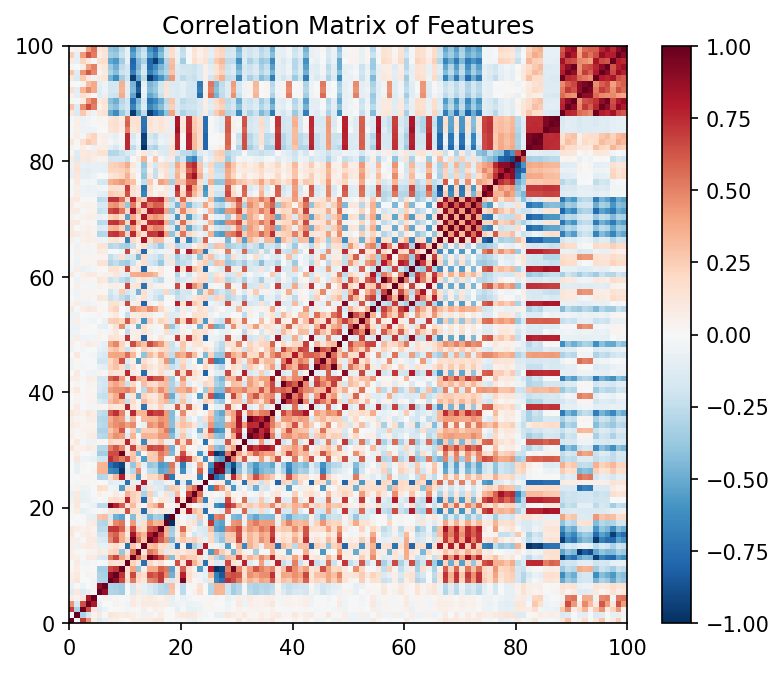

In [25]:
plt.figure(figsize = (6, 5), dpi = 150)
c = plt.pcolor(corr, cmap = "RdBu_r")
plt.title("Correlation Matrix of Features")
plt.colorbar(c)
plt.show()

In [26]:
odf = fdf[["sbp", "dbp"]]
odf

,sbp,dbp
0,99.987120,57.966649
1,100.759058,58.320482
2,102.019124,59.022303
3,102.834648,59.802165
4,100.265742,58.068798
...,...,...
661,158.041383,67.354875
662,154.649431,66.764646
663,160.446045,67.429088
664,165.430557,69.336335


In [27]:
fdf.drop(columns = ["sbp", "dbp"], inplace = True)
fdf

,gender,age,height,weight,bmi,x,y,z,t1,t2,...,bmi/t2,height/t3,weight/t3,bmi/t3,height/tpi,weight/tpi,bmi/tpi,height/tpp,weight/tpp,bmi/tpp
0,1,26.0,183.9,89.05,26.3,1.521116,0.229656,1.627519,61.0,105.0,...,0.250476,3.014754,1.459836,0.431148,1.532500,0.742083,0.219167,1.613158,0.781140,0.230702
1,1,26.0,183.9,89.05,26.3,1.901767,0.289709,1.722940,60.0,102.0,...,0.257843,3.065000,1.484167,0.438333,1.571795,0.761111,0.224786,1.613158,0.781140,0.230702
2,1,26.0,183.9,89.05,26.3,1.584106,0.245259,1.606237,-57.0,97.0,...,0.271134,3.283929,1.590179,0.469643,1.656757,0.802252,0.236937,1.627434,0.788053,0.232743
3,1,26.0,183.9,89.05,26.3,1.462408,0.254907,1.573282,60.0,103.0,...,0.255340,3.065000,1.484167,0.438333,1.558475,0.754661,0.222881,1.627434,0.788053,0.232743
4,1,26.0,183.9,89.05,26.3,1.271244,0.226509,1.503264,-57.0,96.0,...,0.273958,3.343636,1.619091,0.478182,1.671818,0.809545,0.239091,1.641964,0.795089,0.234821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,1,51.0,186.0,81.60,23.6,0.593868,0.052115,0.281505,-52.0,74.0,...,0.318919,4.043478,1.773913,0.513043,2.214286,0.971429,0.280952,1.897959,0.832653,0.240816
662,1,51.0,186.0,81.60,23.6,0.717117,0.092350,0.121180,45.0,81.0,...,0.291358,2.354430,1.032911,0.298734,2.000000,0.877419,0.253763,1.347826,0.591304,0.171014
663,1,51.0,186.0,81.60,23.6,0.894467,0.092680,0.107113,-50.0,81.0,...,0.291358,2.325000,1.020000,0.295000,2.021739,0.886957,0.256522,1.897959,0.832653,0.240816
664,1,51.0,186.0,81.60,23.6,0.418356,0.066924,0.436540,129.0,165.0,...,0.143030,1.441860,0.632558,0.182946,1.044944,0.458427,0.132584,1.162500,0.510000,0.147500


# Feature Selection

## FSCMRMR Method

Tool: https://github.com/smazzanti/mrmr

In [28]:
sbp_features = mrmr.mrmr_regression(X = fdf, y = odf["sbp"], K = 32)
sbp_matrix = fdf[sbp_features]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 48.24it/s]


In [29]:
sbp_features

['t3/y',
 'height',
 'width10/tpi',
 'z/(tpi-t2)',
 'x',
 't2/z',
 'width10/t3',
 'y/(tpi-t3)',
 'age',
 'z',
 'width66/delta_t',
 'width10/t2',
 'y',
 'gender',
 't3/tpp',
 'width66/t2',
 'width10',
 'z/x',
 'width75/t2',
 'width25/t3',
 'tb2',
 'ta2',
 'width75/tpi',
 'ta1',
 't2/tpp',
 'width33/t3',
 'width66/tpi',
 'width25/tpi',
 'width75/delta_t',
 'x/(tpi-t1)',
 'width66',
 'width10/delta_t']

In [30]:
dbp_features = mrmr.mrmr_regression(X = fdf, y = odf["dbp"], K = 32)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 59.68it/s]


In [31]:
dbp_features

['t3/y',
 'height',
 'width10/tpi',
 'z/(tpi-t2)',
 'x',
 'width10/t3',
 't2/z',
 'y',
 'z',
 'width10/t2',
 'y/(tpi-t3)',
 'width25/tpi',
 'width10',
 'width75/t2',
 'width25/t3',
 'z/x',
 'width66/t2',
 'width25/t2',
 'bmi/tpp',
 'width75/tpi',
 't3/tpp',
 'width25',
 '(tb1-tb2)/tpp',
 'tb2',
 'width66/tpi',
 'ta2',
 'width33/t3',
 'x/(tpi-t1)',
 'width10/delta_t',
 'ta1',
 'width75/delta_t',
 'width33/tpi']

## RelieF

In [32]:
# import sklearn_relief as relief

# r = relief.Relief(
#     n_features = 64
# )

# sbp_matrix = r.fit_transform(
#     fdf.to_numpy(),
#     odf["sbp"].to_numpy()
# )

# sbp_matrix = pd.DataFrame(sbp_matrix)
# sbp_matrix.index.name = "number"
# # vals = r.w_.tolist()
# # K = 15
# # vals = np.argpartition(vals,-K)[-K:]
# # fdf.columns[vals]

In [33]:
# sbp_features

# Exporting Features Matrix

## SBP Feature Matrix

In [38]:
feature_matrix = sbp_matrix.join(odf["sbp"], how = "outer")
feature_matrix

,t3/y,height,width10/tpi,z/(tpi-t2),x,t2/z,width10/t3,y/(tpi-t3),age,z,...,ta1,t2/tpp,width33/t3,width66/tpi,width25/tpi,width75/delta_t,x/(tpi-t1),width66,width10/delta_t,sbp
0,265.614877,183.9,0.741667,0.108501,1.521116,64.515384,1.459016,0.101408,26.0,1.627519,...,33.0,0.921053,1.114754,0.366667,0.625000,0.863636,0.025782,44.0,2.022727,99.987120
1,207.104015,183.9,0.000000,0.114863,1.901767,59.201141,0.000000,0.126784,26.0,1.722940,...,29.0,0.894737,1.300000,0.427350,0.743590,1.000000,0.033364,50.0,0.000000,100.759058
2,228.330483,183.9,0.846847,0.114731,1.584106,60.389604,1.678571,0.113150,26.0,1.606237,...,28.0,0.858407,1.267857,0.432432,0.693694,0.259740,0.009429,48.0,0.610390,102.019124
3,235.380221,183.9,0.737288,0.104885,1.462408,65.468226,1.450000,0.097494,26.0,1.573282,...,33.0,0.911504,1.116667,0.372881,0.627119,0.860465,0.025214,44.0,2.023256,102.834648
4,242.815889,183.9,0.781818,0.107376,1.271244,63.861025,1.563636,0.090803,26.0,1.503264,...,28.0,0.857143,1.236364,0.436364,0.663636,0.281046,0.007612,48.0,0.562092,100.265742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,882.667302,186.0,0.000000,0.028151,0.593868,262.872544,0.000000,0.059387,51.0,0.281505,...,22.0,0.755102,1.108696,1.000000,0.000000,0.666667,0.004367,84.0,0.000000,158.041383
662,855.441907,186.0,0.000000,0.010098,0.717117,668.428155,0.000000,0.059760,51.0,0.121180,...,20.0,0.586957,0.797468,0.419355,0.774194,0.944444,0.014940,39.0,0.000000,154.649431
663,863.182784,186.0,0.000000,0.009738,0.894467,756.212724,0.000000,0.081315,51.0,0.107113,...,23.0,0.826531,0.687500,0.239130,0.695652,0.702290,0.006299,22.0,0.000000,160.446045
664,1927.550511,186.0,0.870787,0.033580,0.418356,377.972245,1.201550,0.032181,51.0,0.436540,...,23.0,1.031250,1.069767,0.657303,0.803371,3.055556,0.008538,117.0,4.305556,165.430557


In [39]:
with open("dataset/sbp_features.npy", "wb") as handler:
    np.save(handler, feature_matrix)

## DBP Feature Matrix

In [40]:
feature_matrix = fdf[dbp_features].join(odf["dbp"], how = "outer")
feature_matrix

,t3/y,height,width10/tpi,z/(tpi-t2),x,width10/t3,t2/z,y,z,width10/t2,...,tb2,width66/tpi,ta2,width33/t3,x/(tpi-t1),width10/delta_t,ta1,width75/delta_t,width33/tpi,dbp
0,265.614877,183.9,0.741667,0.108501,1.521116,1.459016,64.515384,0.229656,1.627519,0.847619,...,175.0,0.366667,119.0,1.114754,0.025782,2.022727,33.0,0.863636,0.566667,57.966649
1,207.104015,183.9,0.000000,0.114863,1.901767,0.000000,59.201141,0.289709,1.722940,0.000000,...,174.0,0.427350,118.0,1.300000,0.033364,0.000000,29.0,1.000000,0.666667,58.320482
2,228.330483,183.9,0.846847,0.114731,1.584106,1.678571,60.389604,0.245259,1.606237,0.969072,...,166.0,0.432432,111.0,1.267857,0.009429,0.610390,28.0,0.259740,0.639640,59.022303
3,235.380221,183.9,0.737288,0.104885,1.462408,1.450000,65.468226,0.254907,1.573282,0.844660,...,173.0,0.372881,118.0,1.116667,0.025214,2.023256,33.0,0.860465,0.567797,59.802165
4,242.815889,183.9,0.781818,0.107376,1.271244,1.563636,63.861025,0.226509,1.503264,0.895833,...,165.0,0.436364,111.0,1.236364,0.007612,0.562092,28.0,0.281046,0.618182,58.068798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,882.667302,186.0,0.000000,0.028151,0.593868,0.000000,262.872544,0.052115,0.281505,0.000000,...,126.0,1.000000,84.0,1.108696,0.004367,0.000000,22.0,0.666667,0.607143,67.354875
662,855.441907,186.0,0.000000,0.010098,0.717117,0.000000,668.428155,0.092350,0.121180,0.000000,...,134.0,0.419355,89.0,0.797468,0.014940,0.000000,20.0,0.944444,0.677419,66.764646
663,863.182784,186.0,0.000000,0.009738,0.894467,0.000000,756.212724,0.092680,0.107113,0.000000,...,135.0,0.239130,91.0,0.687500,0.006299,0.000000,23.0,0.702290,0.597826,67.429088
664,1927.550511,186.0,0.870787,0.033580,0.418356,1.201550,377.972245,0.066924,0.436540,0.939394,...,130.0,0.657303,87.0,1.069767,0.008538,4.305556,23.0,3.055556,0.775281,69.336335


In [41]:
with open("dataset/dbp_features.npy", "wb") as handler:
    np.save(handler, feature_matrix)